Processing lambda_0001...
Processing lambda_001...
Processing lambda_01...
Processing lambda_09...
Processing lambda_1...
Processing lambda_10...
Processing lambda_100...
Processing lambda_1000...
Best Lambda for Each Case:
 case_id  best_lambda  expectation_value  qubits
       0       100.00          -0.243037      10
       1      1000.00          -0.298147      10
       2         1.00          -0.250946      10
       3         0.90          -0.063170      10
       4        10.00          -0.247133      10
       5        10.00          -0.244153      10
       6      1000.00          -0.298887      10
       7       100.00          -0.584967      10
       8      1000.00          -0.354326      10
       9         1.00          -0.333131      10
      10        10.00          -0.216369      13
      11       100.00          -0.243468      13
      12         1.00          -0.078931      13
      13        10.00          -0.116347      13
      14        10.00          -0.112723 

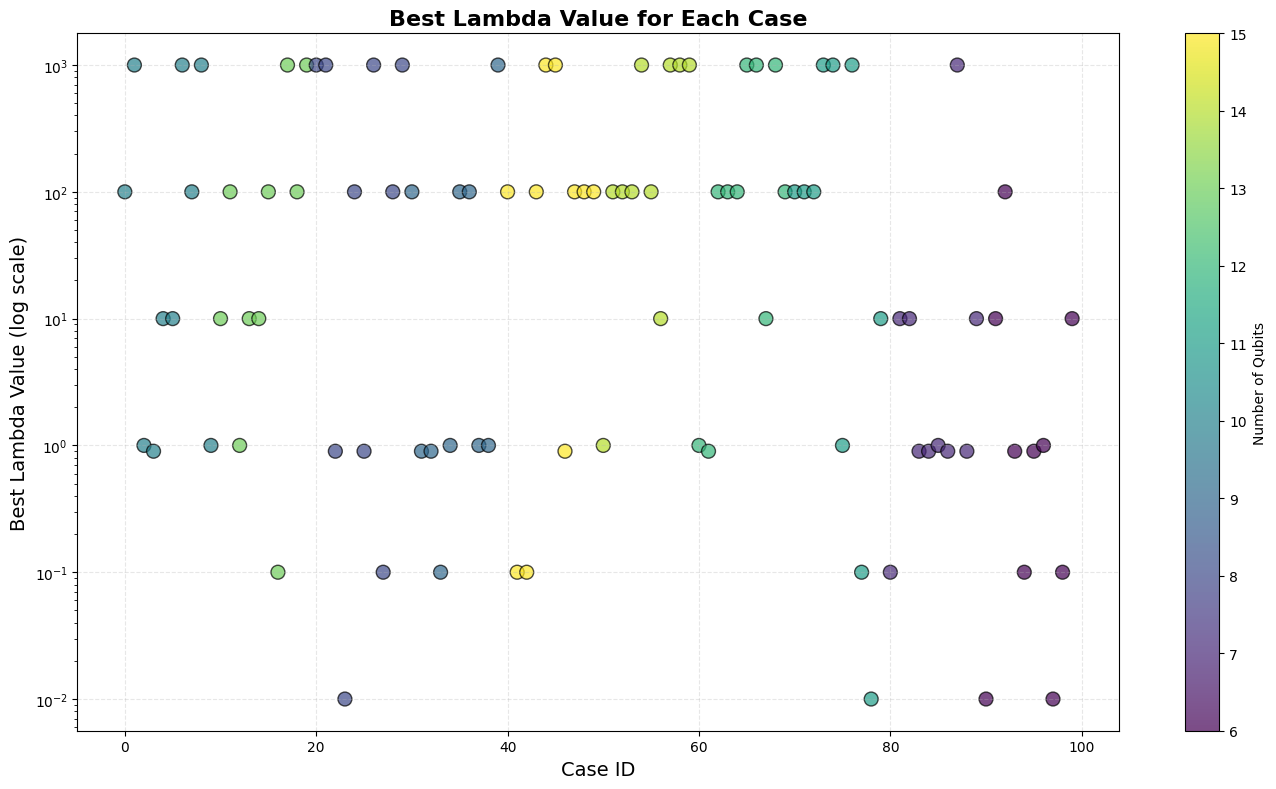

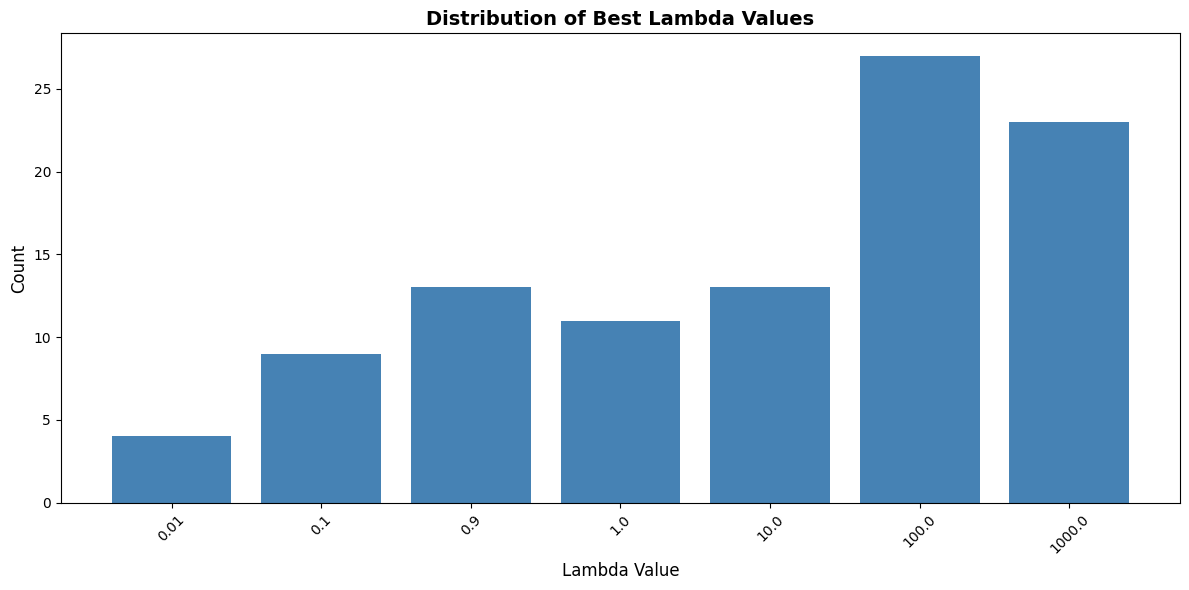

/tmp/ipykernel_5389/4077211408.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='best_lambda', y='expectation_value', data=df, palette='viridis')


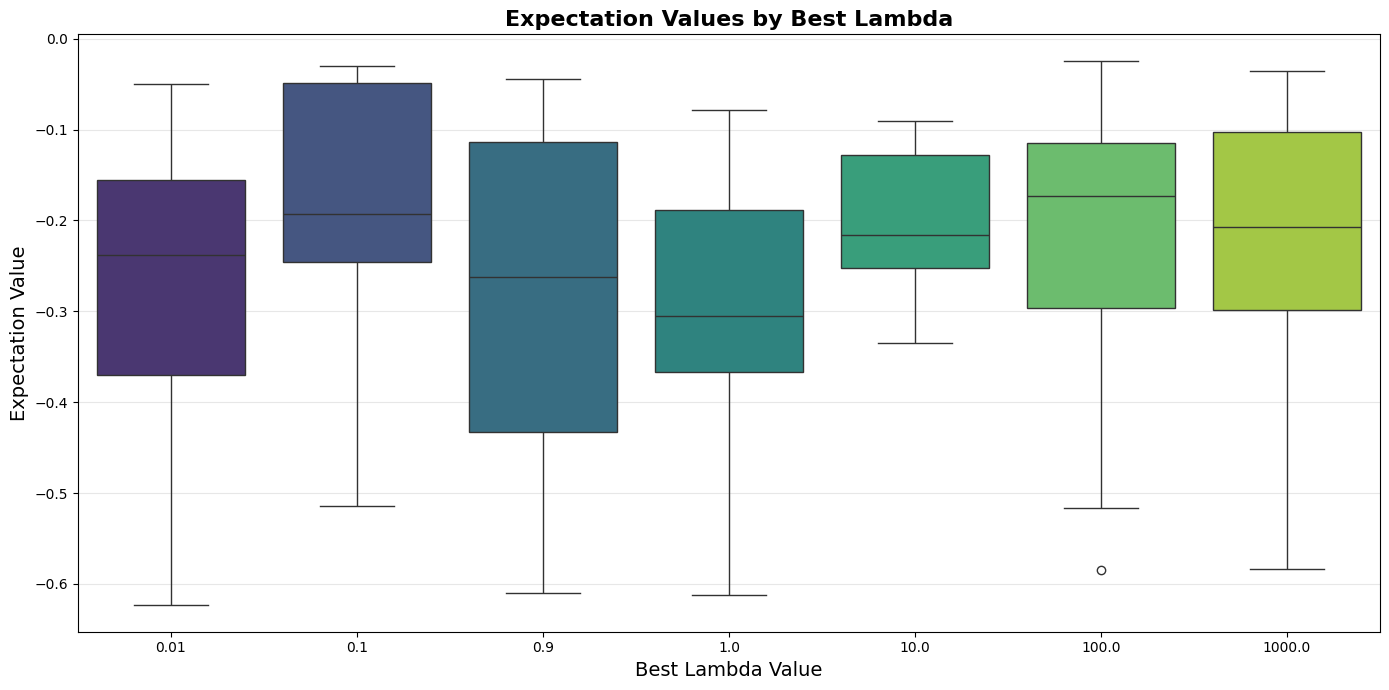

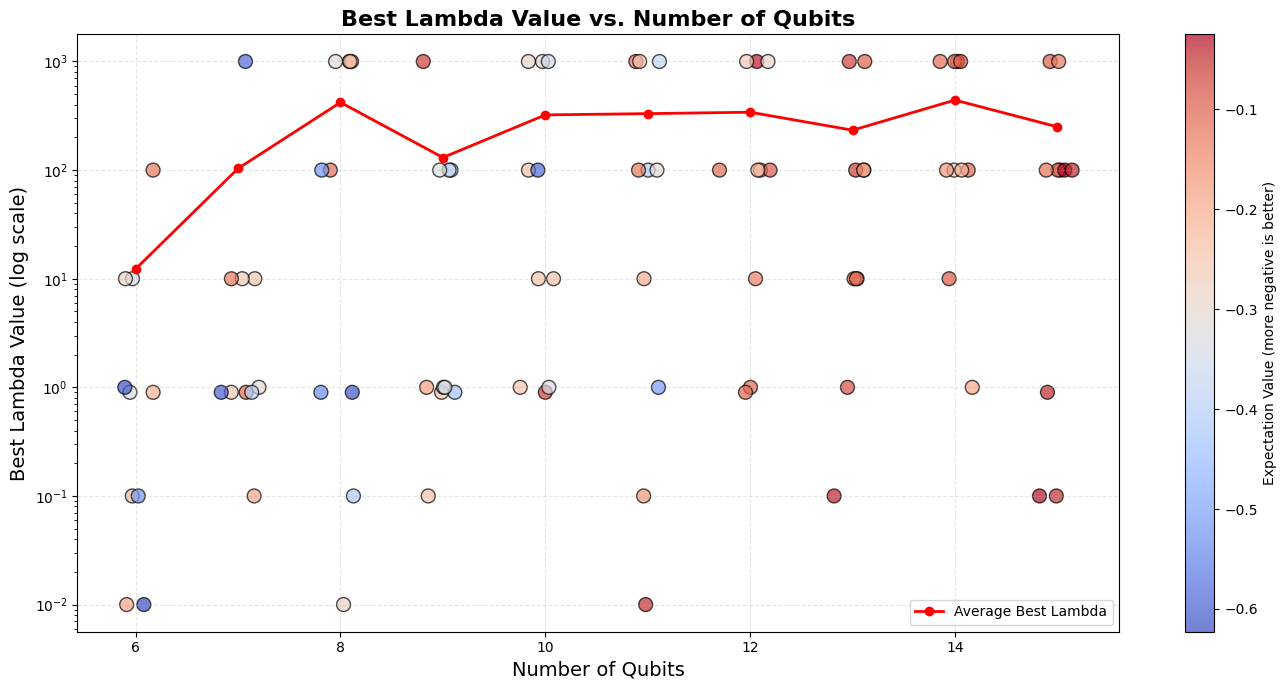


Lambda Recommendation by Qubit Count:
For 6 qubits: Lambda = 0.01 (used in 2/10 cases, 20.0%)
For 7 qubits: Lambda = 0.9 (used in 4/10 cases, 40.0%)
For 8 qubits: Lambda = 1000.0 (used in 4/10 cases, 40.0%)
For 9 qubits: Lambda = 100.0 (used in 3/10 cases, 30.0%)
For 10 qubits: Lambda = 1000.0 (used in 3/10 cases, 30.0%)
For 11 qubits: Lambda = 100.0 (used in 3/10 cases, 30.0%)
For 12 qubits: Lambda = 100.0 (used in 4/10 cases, 40.0%)
For 13 qubits: Lambda = 10.0 (used in 3/10 cases, 30.0%)
For 14 qubits: Lambda = 100.0 (used in 4/10 cases, 40.0%)
For 15 qubits: Lambda = 100.0 (used in 5/10 cases, 50.0%)

Recommended lambda function based on qubit count:
def get_recommended_lambda(n_qubits):
    recommendations = {
        6: 0.01,
        7: 0.9,
        8: 1000.0,
        9: 100.0,
        10: 1000.0,
        11: 100.0,
        12: 100.0,
        13: 10.0,
        14: 100.0,
        15: 100.0,
    }
    return recommendations.get(n_qubits, 1.0)  # Default to 1.0 if qubit count not f

In [2]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def load_json_files(directory):
    """Load all JSON files in a directory"""
    data = {}
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            try:
                with open(file_path, 'r') as f:
                    file_data = json.load(f)
                    data[filename] = file_data
            except:
                print(f"Error loading {file_path}")
    return data

def extract_expectation_values(data, lambda_val):
    """Extract final expectation values from data with the associated lambda value"""
    results = {}
    for filename, file_data in data.items():
        for case_id, case_data in file_data.items():
            if 'qaoa_solution' in case_data and 'final_expectation_value' in case_data['qaoa_solution']:
                if case_id not in results:
                    results[case_id] = {
                        'lambda': lambda_val,
                        'expectation': case_data['qaoa_solution']['final_expectation_value'],
                        'filename': filename,
                        'hyperparams': case_data.get('hyperparams', {})
                    }
                else:
                    # If we have multiple files for the same case_id, take the best one
                    if case_data['qaoa_solution']['final_expectation_value'] < results[case_id]['expectation']:
                        results[case_id]['expectation'] = case_data['qaoa_solution']['final_expectation_value']
                        results[case_id]['filename'] = filename
                        results[case_id]['hyperparams'] = case_data.get('hyperparams', {})
    return results

# Create a dictionary to hold all lambda folders
lambda_dirs = {
    0.001: "lambda_0001",
    0.01: "lambda_001",
    0.1: "lambda_01",
    0.9: "lambda_09",
    1.0: "lambda_1",
    10.0: "lambda_10",
    100.0: "lambda_100",
    1000.0: "lambda_1000"
}

# Base directory where lambda folders are located
base_dir = "../results/cmaes_hubo_results/"

# Create a dictionary to store best results for each case across all lambda values
best_results = {}

# Collect data from all lambda directories
for lambda_val, lambda_dir in lambda_dirs.items():
    directory = os.path.join(base_dir, lambda_dir)
    if os.path.exists(directory):
        print(f"Processing {lambda_dir}...")
        lambda_data = load_json_files(directory)
        case_results = extract_expectation_values(lambda_data, lambda_val)
        
        # Update best_results with better values from this lambda
        for case_id, result in case_results.items():
            if case_id not in best_results or result['expectation'] < best_results[case_id]['expectation']:
                best_results[case_id] = result
    else:
        print(f"Directory not found: {directory}")

# Convert to DataFrame for easier analysis
data_rows = []
for case_id, result in best_results.items():
    data_row = {
        'case_id': int(case_id),
        'best_lambda': result['lambda'],
        'expectation_value': result['expectation'],
        'filename': result['filename']
    }
    
    # Extract qubit count if available
    if 'n_qubits' in result.get('hyperparams', {}):
        data_row['qubits'] = result['hyperparams']['n_qubits']
    
    data_rows.append(data_row)

df = pd.DataFrame(data_rows)

# Sort by case_id for easier reading
df = df.sort_values('case_id')

# Display the best lambda for each case
print("Best Lambda for Each Case:")
case_lambda_df = df[['case_id', 'best_lambda', 'expectation_value', 'qubits']]
print(case_lambda_df.to_string(index=False))

# Create visualizations

# 1. Scatter plot of best lambda by case_id
plt.figure(figsize=(14, 8))

# If we have qubit information, use it for color
if 'qubits' in df.columns:
    scatter = plt.scatter(df['case_id'], df['best_lambda'], 
                         c=df['qubits'], cmap='viridis', 
                         alpha=0.7, s=100, edgecolors='black')
    plt.colorbar(scatter, label='Number of Qubits')
else:
    plt.scatter(df['case_id'], df['best_lambda'], alpha=0.7, s=100, edgecolors='black')

plt.title('Best Lambda Value for Each Case', fontsize=16, fontweight='bold')
plt.xlabel('Case ID', fontsize=14)
plt.ylabel('Best Lambda Value (log scale)', fontsize=14)
plt.yscale('log')  # Use log scale for lambda values
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 2. Distribution of best lambda values
plt.figure(figsize=(12, 6))
lambda_counts = df['best_lambda'].value_counts().sort_index()
plt.bar(lambda_counts.index.astype(str), lambda_counts.values, color='steelblue')
plt.title('Distribution of Best Lambda Values', fontsize=14, fontweight='bold')
plt.xlabel('Lambda Value', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Box plot showing expectation values by best lambda
plt.figure(figsize=(14, 7))
sns.boxplot(x='best_lambda', y='expectation_value', data=df, palette='viridis')
plt.title('Expectation Values by Best Lambda', fontsize=16, fontweight='bold')
plt.xlabel('Best Lambda Value', fontsize=14)
plt.ylabel('Expectation Value', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 4. If we have qubit information, show relationship between qubits and best lambda
if 'qubits' in df.columns:
    plt.figure(figsize=(14, 7))
    
    # Jitter the points to avoid overlap
    x_jitter = np.random.normal(0, 0.1, size=len(df))
    
    # Scatter plot with qubit count on x-axis and best lambda on y-axis
    plt.scatter(df['qubits'] + x_jitter, df['best_lambda'], 
                alpha=0.7, s=100, edgecolors='black',
                c=df['expectation_value'], cmap='coolwarm')
    
    plt.colorbar(label='Expectation Value (more negative is better)')
    plt.title('Best Lambda Value vs. Number of Qubits', fontsize=16, fontweight='bold')
    plt.xlabel('Number of Qubits', fontsize=14)
    plt.ylabel('Best Lambda Value (log scale)', fontsize=14)
    plt.yscale('log')
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Add average lambda line for each qubit count
    avg_lambda = df.groupby('qubits')['best_lambda'].mean()
    plt.plot(avg_lambda.index, avg_lambda.values, 'o-', color='red', 
             linewidth=2, label='Average Best Lambda')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 5. Generate table of lambda recommendations by qubit count
if 'qubits' in df.columns:
    print("\nLambda Recommendation by Qubit Count:")
    qubit_recommendations = df.groupby('qubits')['best_lambda'].value_counts().unstack().fillna(0)
    
    # For each qubit count, find the most common best lambda
    recommended_lambdas = {}
    for qubit in sorted(df['qubits'].unique()):
        best_counts = df[df['qubits'] == qubit]['best_lambda'].value_counts()
        recommended_lambda = best_counts.idxmax()
        count = best_counts.max()
        total = best_counts.sum()
        percentage = (count / total) * 100
        
        recommended_lambdas[qubit] = {
            'lambda': recommended_lambda,
            'count': count,
            'total': total,
            'percentage': percentage
        }
        
        print(f"For {qubit} qubits: Lambda = {recommended_lambda} "
              f"(used in {count}/{total} cases, {percentage:.1f}%)")

    # Create a simple recommendation function
    print("\nRecommended lambda function based on qubit count:")
    # Try to fit a simple relationship if possible
    qubits = np.array(list(recommended_lambdas.keys()))
    lambdas = np.array([data['lambda'] for data in recommended_lambdas.values()])
    
    # Just print the recommendations as a lookup table
    print("def get_recommended_lambda(n_qubits):")
    print("    recommendations = {")
    for qubit, data in recommended_lambdas.items():
        print(f"        {qubit}: {data['lambda']},")
    print("    }")
    print("    return recommendations.get(n_qubits, 1.0)  # Default to 1.0 if qubit count not found")


Analyzing Lambda Impact on Expectation Values by Case:

Top 10 Cases Most Affected by Lambda Choice:
 case_id  qubits  best_lambda  worst_lambda   min_exp   max_exp     diff       cv
      75      11          1.0         0.001 -0.504844 -0.003891 0.500953 0.676372
      70      11        100.0         0.001 -0.411791 -0.003820 0.407972 0.547344
      76      11       1000.0         0.010 -0.379524 -0.000714 0.378810 0.868452
      37       9          1.0         0.001 -0.320012 -0.000622 0.319390 0.754848
      36       9        100.0         0.001 -0.320380 -0.006410 0.313970 0.497365
      87       7       1000.0         0.001 -0.583462 -0.273006 0.310456 0.188883
      71      11        100.0         0.010 -0.311947 -0.019571 0.292376 0.430888
       6      10       1000.0         0.001 -0.298887 -0.016513 0.282374 0.408354
      30       9        100.0         0.010 -0.371168 -0.097125 0.274043 0.291192
       8      10       1000.0         0.001 -0.354326 -0.081468 0.272859 0.287

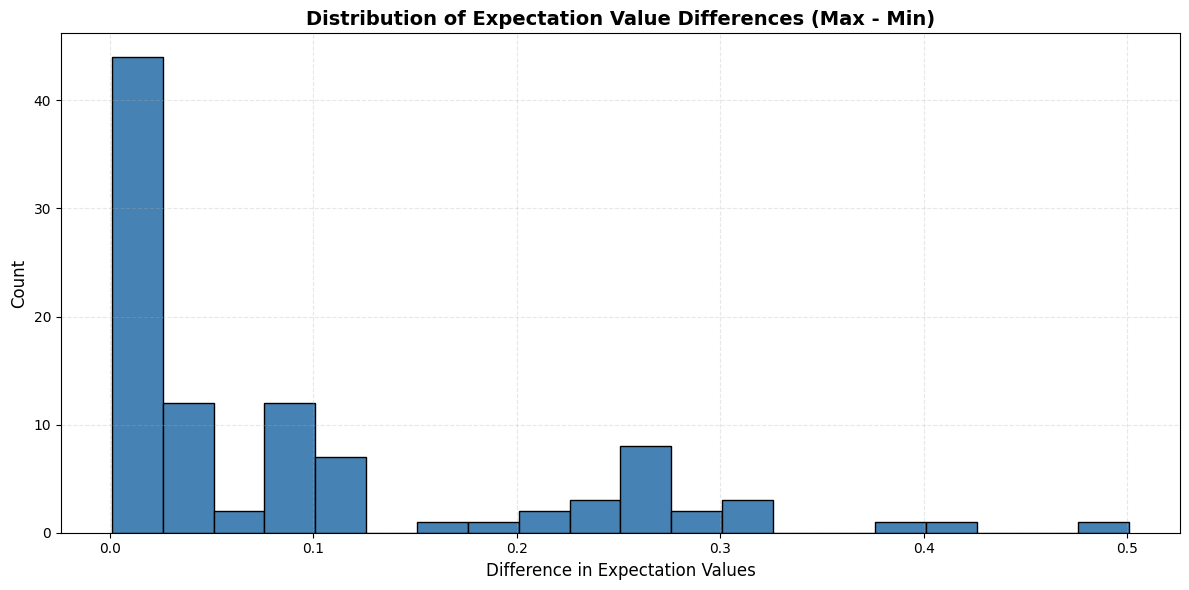

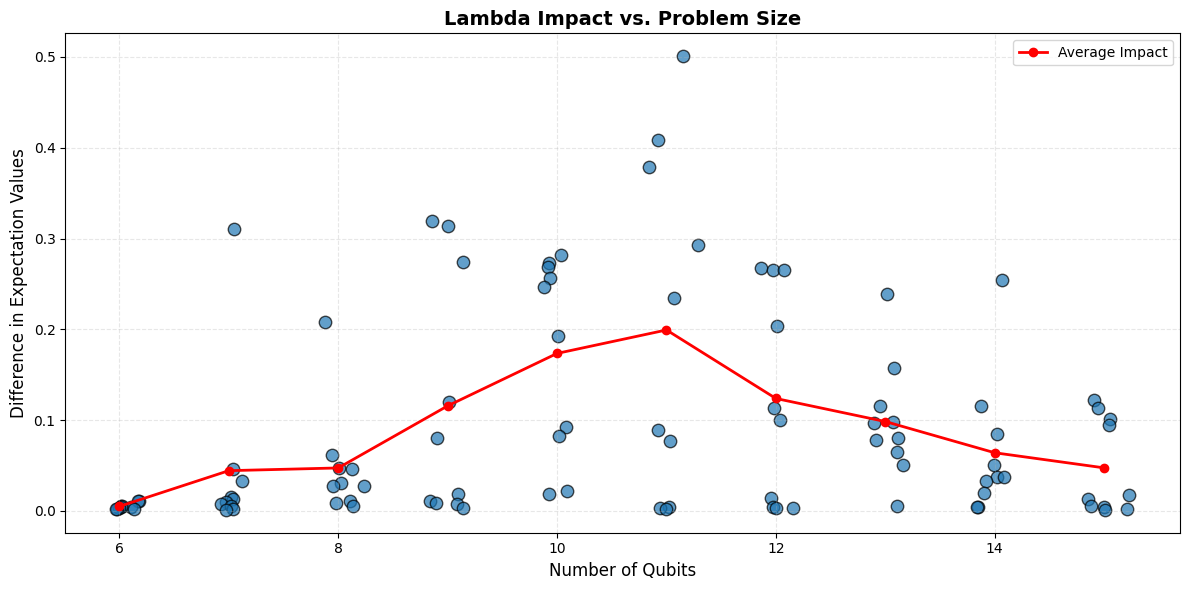

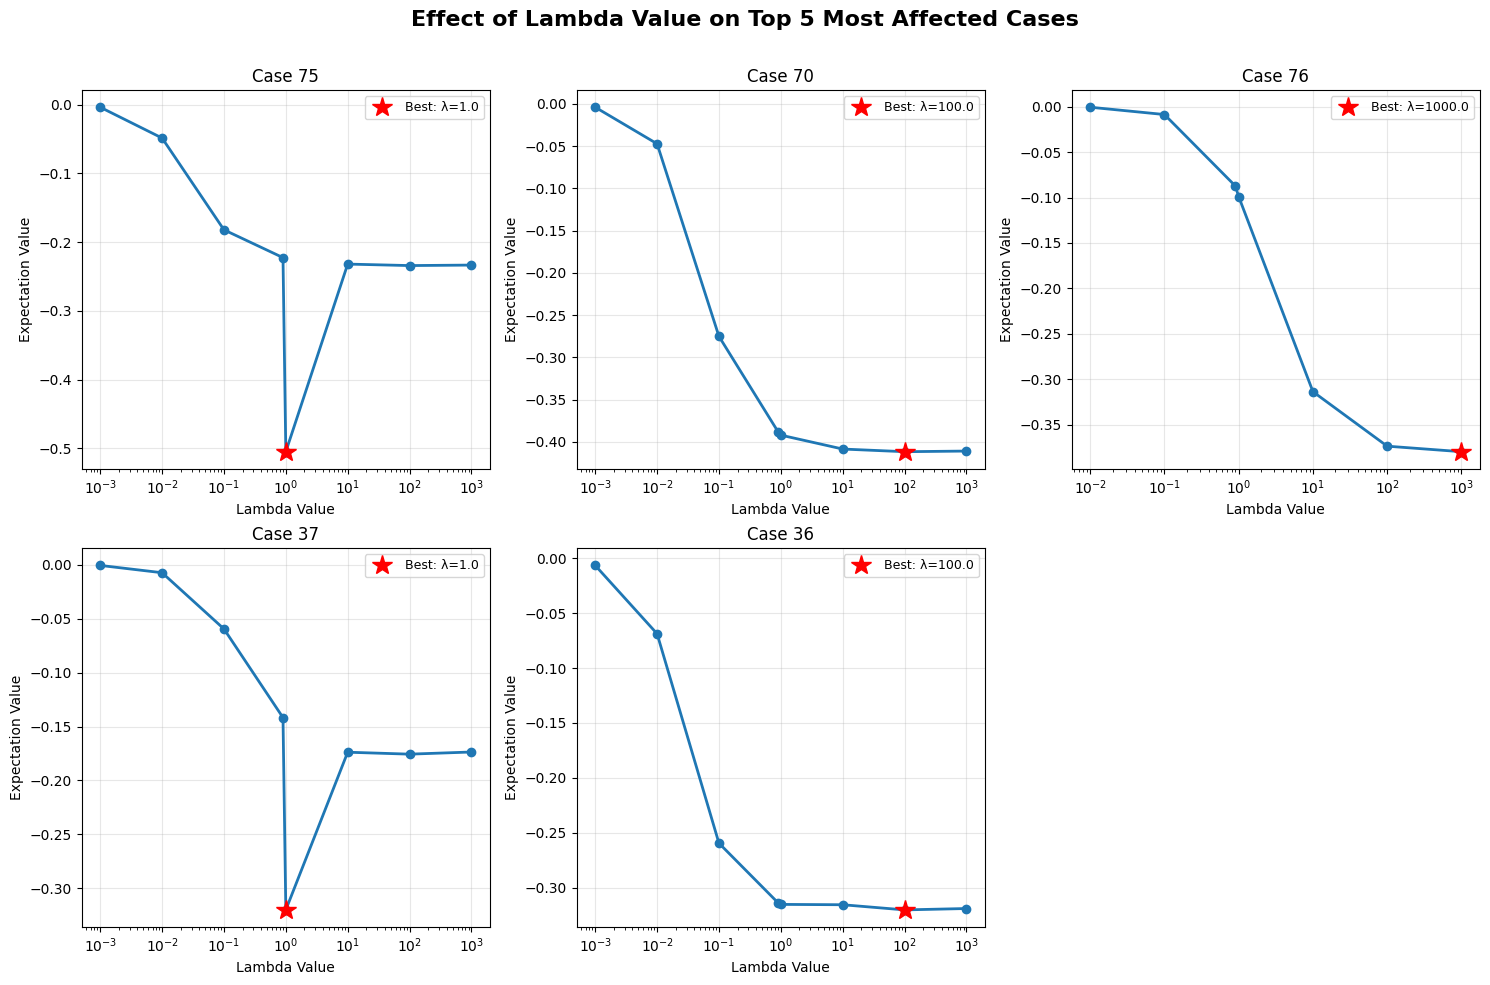

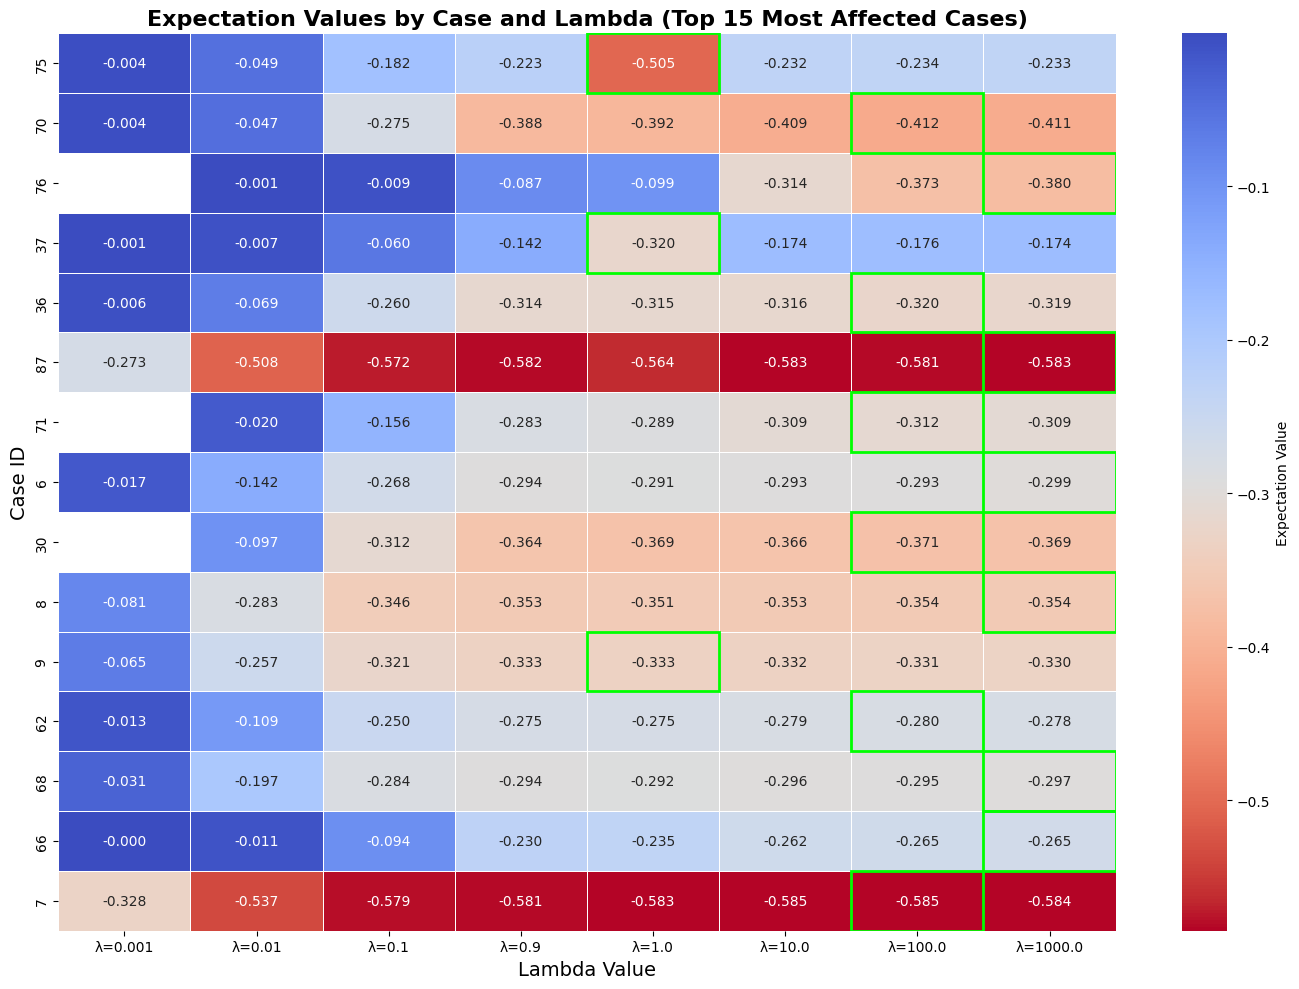


Summary Statistics on Lambda Impact:
Average difference between best and worst lambda: 0.091865
Maximum difference between best and worst lambda: 0.500953
Minimum difference between best and worst lambda: 0.000971
Standard deviation of differences: 0.113650
Average coefficient of variation: 0.195821

Percentage of cases where lambda choice makes a significant difference (>0.01): 69.0%


In [3]:
# 6. Analyze impact of lambda on expectation values for each case
print("\nAnalyzing Lambda Impact on Expectation Values by Case:")

# First, we need to collect all lambda results for each case
all_lambda_results = {}

# Go through all lambda directories again
for lambda_val, lambda_dir in lambda_dirs.items():
    directory = os.path.join(base_dir, lambda_dir)
    if os.path.exists(directory):
        lambda_data = load_json_files(directory)
        case_results = extract_expectation_values(lambda_data, lambda_val)
        
        # Store all results by case_id and lambda_val
        for case_id, result in case_results.items():
            if case_id not in all_lambda_results:
                all_lambda_results[case_id] = {}
            all_lambda_results[case_id][lambda_val] = result['expectation']

# Convert to DataFrame for analysis
lambda_impact_rows = []
for case_id, lambda_results in all_lambda_results.items():
    if len(lambda_results) > 1:  # Only include cases with multiple lambda results
        # Calculate the range of expectation values for this case
        min_exp = min(lambda_results.values())
        max_exp = max(lambda_results.values())
        diff = max_exp - min_exp
        best_lambda = min(lambda_results.items(), key=lambda x: x[1])[0]
        worst_lambda = max(lambda_results.items(), key=lambda x: x[1])[0]
        
        # Calculate average and standard deviation
        avg_exp = np.mean(list(lambda_results.values()))
        std_exp = np.std(list(lambda_results.values()))
        
        # Calculate coefficient of variation (normalized standard deviation)
        # Since expectation values are negative, we use absolute values
        cv = std_exp / abs(avg_exp) if avg_exp != 0 else 0
        
        # Get qubit count if available
        qubits = df[df['case_id'] == int(case_id)]['qubits'].values[0] if int(case_id) in df['case_id'].values else None
        
        lambda_impact_rows.append({
            'case_id': int(case_id),
            'qubits': qubits,
            'best_lambda': best_lambda,
            'worst_lambda': worst_lambda,
            'min_exp': min_exp,
            'max_exp': max_exp,
            'avg_exp': avg_exp,
            'std_exp': std_exp,
            'diff': diff,
            'cv': cv,  # Coefficient of variation
            'lambda_values': len(lambda_results)
        })

lambda_impact_df = pd.DataFrame(lambda_impact_rows)

# Sort by the difference to see which cases are most affected by lambda choice
lambda_impact_df = lambda_impact_df.sort_values('diff', ascending=False)

# Display top 10 cases most affected by lambda
print("\nTop 10 Cases Most Affected by Lambda Choice:")
top_cases = lambda_impact_df.head(10)[['case_id', 'qubits', 'best_lambda', 'worst_lambda', 'min_exp', 'max_exp', 'diff', 'cv']]
print(top_cases.to_string(index=False))

# Visualize the impact of lambda on expectation values

# 1. Distribution of expectation value differences
plt.figure(figsize=(12, 6))
plt.hist(lambda_impact_df['diff'], bins=20, color='steelblue', edgecolor='black')
plt.title('Distribution of Expectation Value Differences (Max - Min)', fontsize=14, fontweight='bold')
plt.xlabel('Difference in Expectation Values', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 2. Scatter plot of difference vs. qubit count
if 'qubits' in lambda_impact_df.columns:
    plt.figure(figsize=(12, 6))
    
    # Jitter the x-axis to avoid overlapping points
    x_jitter = np.random.normal(0, 0.1, size=len(lambda_impact_df))
    
    plt.scatter(lambda_impact_df['qubits'] + x_jitter, lambda_impact_df['diff'], 
                alpha=0.7, s=80, edgecolors='black')
    plt.title('Lambda Impact vs. Problem Size', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Qubits', fontsize=12)
    plt.ylabel('Difference in Expectation Values', fontsize=12)
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Add trend line
    qubit_groups = lambda_impact_df.groupby('qubits')['diff'].mean()
    plt.plot(qubit_groups.index, qubit_groups.values, 'ro-', linewidth=2, label='Average Impact')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 3. Plot the range of expectation values for the top 5 most affected cases
top_5_cases = lambda_impact_df.head(5)['case_id'].tolist()

plt.figure(figsize=(15, 10))

for i, case_id in enumerate(top_5_cases):
    lambda_vals = []
    exp_vals = []
    
    for lambda_val in sorted(all_lambda_results[str(case_id)].keys()):
        lambda_vals.append(lambda_val)
        exp_vals.append(all_lambda_results[str(case_id)][lambda_val])
    
    plt.subplot(2, 3, i + 1)
    plt.plot(lambda_vals, exp_vals, 'o-', linewidth=2)
    plt.xscale('log')
    plt.title(f'Case {case_id}', fontsize=12)
    plt.xlabel('Lambda Value', fontsize=10)
    plt.ylabel('Expectation Value', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Highlight best lambda
    best_lambda = min(all_lambda_results[str(case_id)].items(), key=lambda x: x[1])[0]
    best_exp = all_lambda_results[str(case_id)][best_lambda]
    plt.plot(best_lambda, best_exp, 'r*', markersize=15, label=f'Best: λ={best_lambda}')
    plt.legend(fontsize=9)

plt.tight_layout()
plt.suptitle('Effect of Lambda Value on Top 5 Most Affected Cases', fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.9)
plt.show()

# 4. Heatmap showing expectation values for all cases and lambdas
# Prepare data for heatmap
heatmap_data = {}
lambda_values = sorted(lambda_dirs.keys())

# Select a subset of cases (e.g., top 15 most affected)
selected_cases = lambda_impact_df.head(15)['case_id'].tolist()

for case_id in selected_cases:
    case_str = str(case_id)
    heatmap_data[case_id] = []
    
    for lambda_val in lambda_values:
        if case_str in all_lambda_results and lambda_val in all_lambda_results[case_str]:
            heatmap_data[case_id].append(all_lambda_results[case_str][lambda_val])
        else:
            heatmap_data[case_id].append(np.nan)  # No data for this combination

# Convert to DataFrame
heatmap_df = pd.DataFrame(heatmap_data, index=lambda_values).T
heatmap_df.columns = [f"λ={lam}" for lam in lambda_values]

# Create heatmap
plt.figure(figsize=(14, 10))
ax = sns.heatmap(heatmap_df, cmap='coolwarm_r', annot=True, fmt='.3f', 
                linewidths=0.5, cbar_kws={'label': 'Expectation Value'})
plt.title('Expectation Values by Case and Lambda (Top 15 Most Affected Cases)', fontsize=16, fontweight='bold')
plt.xlabel('Lambda Value', fontsize=14)
plt.ylabel('Case ID', fontsize=14)

# Highlight the best (minimum) value in each row
for i in range(len(heatmap_df)):
    row = heatmap_df.iloc[i].values
    j = np.nanargmin(row)  # Find index of minimum value in row, ignoring NaN
    if not np.isnan(row[j]):  # Make sure it's not NaN
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='lime', lw=2))

plt.tight_layout()
plt.show()

# 5. Calculate and display overall statistics
print("\nSummary Statistics on Lambda Impact:")
print(f"Average difference between best and worst lambda: {lambda_impact_df['diff'].mean():.6f}")
print(f"Maximum difference between best and worst lambda: {lambda_impact_df['diff'].max():.6f}")
print(f"Minimum difference between best and worst lambda: {lambda_impact_df['diff'].min():.6f}")
print(f"Standard deviation of differences: {lambda_impact_df['diff'].std():.6f}")
print(f"Average coefficient of variation: {lambda_impact_df['cv'].mean():.6f}")

# Calculate what percentage of cases show significant impact
significant_threshold = 0.01  # Define what constitutes a "significant" difference
significant_cases = lambda_impact_df[lambda_impact_df['diff'] > significant_threshold]
significant_pct = len(significant_cases) / len(lambda_impact_df) * 100

print(f"\nPercentage of cases where lambda choice makes a significant difference (>{significant_threshold}): {significant_pct:.1f}%")